# Splink tests 2

Somewhere clean to tighten up the pipeline as I get to a quicker iteration.

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import IFrame
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import duckdb
import pandas as pd
import polars as pl
import random
import datetime
import os

import altair as alt
alt.renderers.enable("mimetype")

from src.models import model_train as ld
from src.features.clean_complex import clean_comp_names
from src.config import stopwords
from src.config import settings
from src.features.clean_basic import (
    remove_notnumbers_leadingzeroes,
    clean_company_name,
    array_except,
    array_intersect,
    list_join_to_string,
)
from src import locations as loc

from splink.duckdb.linker import DuckDBLinker
from splink.charts import save_offline_chart

RendererRegistry.enable('mimetype')

# TODO

21/6. I've got a strategy. I have example queries that use a generated lookup to join n number of target tables to a source, both permitting and not permitting duplication in the target. I believe that link_and_dedupe will create the clusters I need to successfully sort this out.

The blocking rules are hugely improved but estimating m is taking weirdly long. I think replacing '' with nulls will sort this out.

* Change '' to nulls in data selection -- suspect this is what's slowing down m estimation in the company_number column (tonnes of false dupes)
* Figure out why dupes in EW aren't in one cluster
    * Changed linker to link_and_dedupe -- needs testing
    * If this works, ready to productionise

## Data

Data we need to bring in:

* ✅ Companies house
* ✅ Data Hub companies
* ✅ HMRC exporters
* ✅ Export wins

In [11]:
df_ch = ld.comp_house_read(100_000)
df_ch_clean = ld.clean_numbers_and_names(df_ch)

/opt/conda/envs/lead_generation_experiments/lib/python3.9/site-packages/pandas/io/sql.py:1410: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  meta = MetaData(self.connectable, schema=schema)


In [12]:
df_dh = ld.data_hub_read(100_000)
df_dh_clean = ld.clean_numbers_and_names(df_dh)

In [13]:
df_ex = ld.hmrc_exporters_read(100_000)
df_ex_clean = ld.clean_numbers_and_names(df_ex)

In [14]:
df_ew = ld.export_wins_read(100_000)
df_ew_clean = ld.clean_numbers_and_names(df_ew)

## Link and predict

In [15]:
linker = DuckDBLinker(
    [
        df_dh_clean, 
        df_ch_clean, 
        df_ex_clean, 
        df_ew_clean
    ],
    settings,
    input_table_aliases=[
        "dit_data_hub__companies", 
        "companieshouse_companies", 
        "hmrc_trade__exporters", 
        "dit_export_wins__wins_dataset"
    ],
)

In [16]:
linker.estimate_probability_two_random_records_match(
    "l.name_unusual_tokens = r.name_unusual_tokens",
    recall=0.7,
)

Probability two random records match is estimated to be  8.85e-06.
This means that amongst all possible pairwise record comparisons, one in 112,941.61 are expected to match.  With 62,627,736,655 total possible comparisons, we expect a total of around 554,514.29 matching pairs


In [17]:
linker.estimate_u_using_random_sampling(max_pairs=1e7)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - comp_num_clean (no m values are trained).
    - name_unusual_tokens (no m values are trained).
    - postcode (no m values are trained).


In [18]:
linker.estimate_m_from_label_column("comp_num_clean")

---- Estimating m probabilities using from column comp_num_clean -----
m probability not trained for comp_num_clean - Jaro_winkler_similarity >= 0.75 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
m probability not trained for comp_num_clean - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.

Your model is not yet fully trained. Missing estimates for:
    - comp_num_clean (some m values are not trained).


In [19]:
m_by_name_and_postcode_area = "l.name_unusual_tokens = r.name_unusual_tokens and l.postcode_area = r.postcode_area"
linker.estimate_parameters_using_expectation_maximisation(m_by_name_and_postcode_area)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.name_unusual_tokens = r.name_unusual_tokens and l.postcode_area = r.postcode_area

Parameter estimates will be made for the following comparison(s):
    - comp_num_clean
    - postcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - name_unusual_tokens


Level All other comparisons on comparison postcode not observed in dataset, unable to train m value
Iteration 1: Largest change in params was -0.754 in the m_probability of postcode, level `All other comparisons`

Level All other comparisons on comparison postcode not observed in dataset, unable to train m value
Iteration 2: Largest change in params was 0.0448 in probability_two_random_records_match

Level All other comparisons on comparison postcode not observed in dataset, unable to train m value
Iteration 3: Largest change in params was -0.00363 in the m_probab

<EMTrainingSession, blocking on l.name_unusual_tokens = r.name_unusual_tokens and l.postcode_area = r.postcode_area, deactivating comparisons name_unusual_tokens>

In [20]:
predictions = linker.predict(threshold_match_probability=0.7)

In [21]:
df_predict = predictions.as_pandas_dataframe()

In [93]:
df_predict.source_dataset_l.value_counts()
df_predict.source_dataset_r.value_counts()

dit_export_wins__wins_dataset    145293
hmrc_trade__exporters             66647
dit_data_hub__companies           26615
companieshouse_companies           2504
Name: source_dataset_l, dtype: int64

dit_export_wins__wins_dataset    154230
hmrc_trade__exporters             85181
dit_data_hub__companies            1616
companieshouse_companies             32
Name: source_dataset_r, dtype: int64

In [94]:
predictions_2 = linker.predict()
predictions_2 = predictions_2.as_pandas_dataframe()
predictions_2.source_dataset_l.value_counts()
predictions_2.source_dataset_r.value_counts()

dit_export_wins__wins_dataset    256527
dit_data_hub__companies           76777
hmrc_trade__exporters             73356
companieshouse_companies           5508
Name: source_dataset_l, dtype: int64

dit_export_wins__wins_dataset    257237
hmrc_trade__exporters            143475
dit_data_hub__companies           11239
companieshouse_companies            217
Name: source_dataset_r, dtype: int64

In [95]:
(
    pl.from_pandas(predictions_2)
    .filter(pl.col('source_dataset_r') == 'hmrc_trade__exporters')
    .sort(by = 'match_probability', descending = True)
    .head(5)
)

match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,comp_num_clean_l,comp_num_clean_r,gamma_comp_num_clean,tf_comp_num_clean_l,tf_comp_num_clean_r,bf_comp_num_clean,bf_tf_adj_comp_num_clean,name_unusual_tokens_l,name_unusual_tokens_r,gamma_name_unusual_tokens,tf_name_unusual_tokens_l,tf_name_unusual_tokens_r,bf_name_unusual_tokens,bf_tf_adj_name_unusual_tokens,postcode_l,postcode_r,gamma_postcode,bf_postcode,secondary_name_unusual_tokens_l,secondary_name_unusual_tokens_r,match_key
f64,f64,str,str,str,str,str,str,i32,f64,f64,f64,f64,str,str,i32,f64,f64,f64,f64,str,str,i32,f64,str,str,str
8.450592,0.99715,"""companieshouse…","""hmrc_trade__ex…","""06274585""","""1418546""","""6274585""",null,-1,0.000005,null,1.0,1.0,"""magawell""","""magawell""",3,0.000006,0.000006,67666.27948,1.134151,"""NP11 5GT""","""NP11 5GT""",4,520.071434,"""""",null,"""1"""
8.450592,0.99715,"""companieshouse…","""hmrc_trade__ex…","""05401138""","""2611486""","""5401138""",null,-1,0.000005,null,1.0,1.0,"""springcoil""","""springcoil""",3,0.000006,0.000006,67666.27948,1.134151,"""S9 3NE""","""S9 3NE""",4,520.071434,"""""",null,"""1"""
8.450592,0.99715,"""companieshouse…","""hmrc_trade__ex…","""03413004""","""2871186""","""3413004""",null,-1,0.000005,null,1.0,1.0,"""europe stoneag…","""europe stoneag…",3,0.000006,0.000006,67666.27948,1.134151,"""WR5 2DQ""","""WR5 2DQ""",4,520.071434,"""aquapower salo…",null,"""1"""
8.450592,0.99715,"""companieshouse…","""hmrc_trade__ex…","""05434133""","""1269999""","""5434133""",null,-1,0.000005,null,1.0,1.0,"""dellner""","""dellner""",3,0.000006,0.000006,67666.27948,1.134151,"""DE11 9DX""","""DE11 9DX""",4,520.071434,"""couplers delln…",null,"""1"""
8.450592,0.99715,"""companieshouse…","""hmrc_trade__ex…","""12208468""","""2654556""","""12208468""",null,-1,0.000005,null,1.0,1.0,"""cocompany ligh…","""cocompany ligh…",3,0.000006,0.000006,67666.27948,1.134151,"""CM7 3QS""","""CM7 3QS""",4,520.071434,"""""",null,"""1"""


## Cluster experiment 2

In [32]:
clusters = linker.cluster_pairwise_predictions_at_threshold(
    predictions,
    threshold_match_probability = 0.7
)

Completed iteration 1, root rows count 1
Completed iteration 2, root rows count 0


In [134]:
linker.cluster_studio_dashboard(
    predictions, 
    clusters, 
    "cluster_studio.html", 
    sampling_method="by_cluster_size", 
    overwrite=True
)

In [135]:
IFrame(
    src="./cluster_studio.html", 
    width="100%", 
    height=1000
)

## Cluster experiment 1

In [22]:
clusters = linker.cluster_pairwise_predictions_at_threshold(
    predictions,
    threshold_match_probability=0.7,
    pairwise_formatting=True,
    filter_pairwise_format_for_clusters=False,
)

Completed iteration 1, root rows count 26
Completed iteration 2, root rows count 0


In [23]:
df_clusters = clusters.as_pandas_dataframe()

In [43]:
df_clusters[df_clusters.cluster_id_l != df_clusters.cluster_id_r].head(5)

,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,comp_num_clean_l,comp_num_clean_r,gamma_comp_num_clean,tf_comp_num_clean_l,tf_comp_num_clean_r,bf_comp_num_clean,bf_tf_adj_comp_num_clean,name_unusual_tokens_l,name_unusual_tokens_r,gamma_name_unusual_tokens,tf_name_unusual_tokens_l,tf_name_unusual_tokens_r,bf_name_unusual_tokens,bf_tf_adj_name_unusual_tokens,postcode_area_l,postcode_area_r,gamma_postcode_area,bf_postcode_area,secondary_name_unusual_tokens_l,secondary_name_unusual_tokens_r,match_key,cluster_id_l,cluster_id_r


I told Leo there was a problem when these don't match. I think they only don't match when the _prediction_ threshold and _clustering_ threshold don't match. When clustering is higher than prediction, you end up with dangling, clusterless matches in the pairwise dataframe.

Consider the following where prediction threshold was 0.5:

```
A -> B (0.5)
B -> C (0.7)
```

With clustering threshold 0.7:

```
A, 1
B, 2
C, 2
```

And in the pairwise dataframe:

```
A (cluster 1) -> B (cluster 2) (0.5)
B (cluster 2) -> C (cluster 2) (0.7)
```

But if they both match, where the prediction and clustering thresholds are both 0.5:

```
A (cluster 1) -> B (cluster 1) (0.5)
B (cluster 1) -> C (cluster 1) (0.7)
```

Indeed, we can confirm by forcing the imbalance and checking that every combination of cluster l/r is unique in the clustering mismatches in the pairwise dataframe. They are.

In [44]:
(
    pl.from_pandas(df_clusters[df_clusters.cluster_id_l != df_clusters.cluster_id_r])
    .groupby(['cluster_id_l', 'cluster_id_r'])
    .count()
    .filter(pl.col('count') > 1)
)

cluster_id_l,cluster_id_r,count
str,str,u32


In [74]:
df_clusters.source_dataset_l.value_counts()
df_clusters.source_dataset_r.value_counts()

dit_export_wins__wins_dataset    146817
dit_data_hub__companies            8967
companieshouse_companies           1289
Name: source_dataset_l, dtype: int64

dit_export_wins__wins_dataset    155957
dit_data_hub__companies            1116
Name: source_dataset_r, dtype: int64

In [24]:
lookup = duckdb.sql("""
    select
        source_dataset_l as source,
        unique_id_l as source_id,
        cluster_id_l as source_cluster,
        source_dataset_r as target,
        unique_id_r as target_id,
        cluster_id_r as target_cluster,
        match_probability
    from
        df_clusters
    union
    select
        source_dataset_r as source,
        unique_id_r as source_id,
        cluster_id_r as source_cluster,
        source_dataset_l as target,
        unique_id_l as target_id,
        cluster_id_l as target_cluster,
        match_probability
    from
        df_clusters
""")

In [99]:
lookup.df().source.value_counts()

dit_export_wins__wins_dataset    299523
hmrc_trade__exporters            151828
dit_data_hub__companies           28231
companieshouse_companies           2536
Name: source, dtype: int64

In [42]:
lookup.df()

,source,source_id,source_cluster,target,target_id,target_cluster,match_probability
0,dit_export_wins__wins_dataset,1dbec4d3-da65-4642-b343-4e611f41982d,dit_export_wins__wins_dataset-__-1dbec4d3-da65...,dit_export_wins__wins_dataset,a9a73745-1696-48bd-beb7-522a2cd325c6,dit_export_wins__wins_dataset-__-1dbec4d3-da65...,0.999913
1,dit_export_wins__wins_dataset,2e724392-abcf-437e-a8c5-fec6f2a72fe2,dit_export_wins__wins_dataset-__-1dc53fda-805a...,dit_export_wins__wins_dataset,b9b3badd-68a9-48f8-b800-50ac146bf91c,dit_export_wins__wins_dataset-__-1dc53fda-805a...,0.999935
2,dit_export_wins__wins_dataset,1df38b15-ba6e-4378-9ded-753cc27dc87d,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,dit_export_wins__wins_dataset,3485848d-8ffd-4ef1-a4ee-479d47bc448b,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,0.999674
3,dit_export_wins__wins_dataset,1df38b15-ba6e-4378-9ded-753cc27dc87d,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,dit_export_wins__wins_dataset,764b6f8a-4ac8-4b5f-a8f3-3164ff41d4b9,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,0.999674
4,dit_export_wins__wins_dataset,764b6f8a-4ac8-4b5f-a8f3-3164ff41d4b9,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,dit_export_wins__wins_dataset,e6b6f554-f5ff-4658-8079-0134e09e00a0,dit_export_wins__wins_dataset-__-1df38b15-ba6e...,0.999674
...,...,...,...,...,...,...,...
313537,dit_export_wins__wins_dataset,ecd3306e-1909-461f-b994-c028da621ca9,dit_export_wins__wins_dataset-__-0e68c25c-0230...,dit_export_wins__wins_dataset,409b43e7-14d6-488e-9bb9-de81c7aa3704,dit_export_wins__wins_dataset-__-0e68c25c-0230...,0.999823
313538,dit_export_wins__wins_dataset,d3bbbb75-34eb-43c0-bfbf-d772b64d1a72,dit_export_wins__wins_dataset-__-0e6f01a3-98be...,dit_export_wins__wins_dataset,8c1940f2-6c0c-4aee-97cc-1ee67937c0d3,dit_export_wins__wins_dataset-__-0e6f01a3-98be...,0.999772
313539,dit_export_wins__wins_dataset,cb3a076c-bc51-4950-a31a-0e47029ab1de,dit_export_wins__wins_dataset-__-0e714516-011d...,dit_export_wins__wins_dataset,47d90de2-7ee4-45b9-a3c4-dd92e3ab7132,dit_export_wins__wins_dataset-__-0e714516-011d...,0.999436
313540,dit_export_wins__wins_dataset,a5699268-a2e9-4d8b-9b15-0956dc37f36c,dit_export_wins__wins_dataset-__-0e714516-011d...,dit_export_wins__wins_dataset,6599a87b-2e42-4e99-bcf1-cbcc7695dd77,dit_export_wins__wins_dataset-__-0e714516-011d...,0.999436


In [100]:
duckdb.sql("""
    select
        dh.company_name,
        ew.company_name
    from
        lookup lookup
    inner join df_dh dh on
        lookup.source_id = dh.unique_id and
        lookup.source = 'dit_data_hub__companies'
    inner join df_ew ew on
        lookup.target_id = ew.unique_id and
        lookup.target = 'dit_export_wins__wins_dataset'
""")

┌──────────────────────────────────┬──────────────────────────────────┐
│           company_name           │           company_name           │
│             varchar              │             varchar              │
├──────────────────────────────────┼──────────────────────────────────┤
│ MICRO:BIT EDUCATIONAL FOUNDATION │ MICRO:BIT EDUCATIONAL FOUNDATION │
│ TSL PROFESSIONAL PRODUCTS LTD.   │ TSL Professional Products Ltd    │
│ FORTIS TECHNOLOGIES LIMITED      │ FORTIS TECHNOLOGIES LIMITED      │
│ RAILD IMPORTS LIMITED            │ Raild Imports Ltd                │
│ DOMINO UK LIMITED                │ Domino UK Ltd                    │
│ PS DISTRIBUTION LTD              │ PS DISTRIBUTION LTD              │
│ WILD LIFE WORLD LIMITED          │ Wild Life World                  │
│ PEAK COMMUNICATIONS LIMITED      │ Peak Communications Limited      │
│ ANYWHERE WI-FI LIMITED           │ ANYWHERE WI-FI LIMITED           │
│ THERMOTEKNIX SYSTEMS LIMITED     │ Thermoteknix Systems Ltd   

## Lookup testing

In [16]:
lookup = duckdb.sql("""
    select
        source_dataset_l as source,
        unique_id_l as source_id,
        cluster_id_l as source_cluster,
        source_dataset_r as target,
        unique_id_r as target_id,
        cluster_id_r as target_cluster,
        match_probability
    from
        df_clusters
    union
    select
        source_dataset_r as source,
        unique_id_r as source_id,
        cluster_id_r as source_cluster,
        source_dataset_l as target,
        unique_id_l as target_id,
        cluster_id_l as target_cluster,
        match_probability
    from
        df_clusters
""")

21/6: This seems like the best selection method for joining an eventual lookup. This RETAINS duplicates. If there are lots of export wins in the target dataset, every one is getting returned. 

In [17]:
join_with_dupes = duckdb.sql("""
    select
        ch.unique_id,
        ch.company_name as ch_name,
        dh.company_name as dh_name,
        ew.company_name as ew_name
    from (
        select 
            *
        from
            lookup lookup
        where
            lookup.source = 'companieshouse_companies'
            and lookup.target in (
                'dit_data_hub__companies',
                'dit_export_wins__wins_dataset'
            )
    ) lookup
    right outer join df_ch ch on
        lookup.source_id = ch.unique_id 
        and lookup.source = 'companieshouse_companies'
    left join df_dh dh on
        lookup.target_id = dh.unique_id 
        and lookup.target = 'dit_data_hub__companies'
    left join df_ew ew on
        lookup.target_id = ew.unique_id
        and lookup.target = 'dit_export_wins__wins_dataset'
""")

join_with_dupes.df().shape
join_with_dupes

(100273, 4)

┌───────────┬─────────────────────────────────────────────┬─────────────────────────────────────────────┬─────────┐
│ unique_id │                   ch_name                   │                   dh_name                   │ ew_name │
│  varchar  │                   varchar                   │                   varchar                   │ varchar │
├───────────┼─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────┤
│ 01341280  │ T.E.L. ENGINEERING LIMITED                  │ T.E.L. ENGINEERING LIMITED                  │ NULL    │
│ 02925653  │ CORPORATE DOCUMENT SERVICES LIMITED         │ CORPORATE DOCUMENT SERVICES LIMITED         │ NULL    │
│ 04650763  │ KEYSTONE LAW LIMITED                        │ KEYSTONE LAW LIMITED                        │ NULL    │
│ 05517238  │ DESCOMED LIMITED                            │ DESCOMED LIMITED                            │ NULL    │
│ 05912338  │ IMA (KLESSMANN) UK LTD                      │ IMA (KLESSMA

In [120]:
join_with_dupes.df()['unique_id'].nunique()
join_with_dupes.df()[['dh_name', 'ew_name']].notnull().sum()

100000

dh_name    972
ew_name    369
dtype: int64

In [122]:
duckdb.sql("""
    select
        unique_id,
        count(*)
    from
        join_with_dupes
    group by
        unique_id
    having
        count(*) > 1
    order by
        count(*) desc
    limit
        5
""")

┌───────────┬──────────────┐
│ unique_id │ count_star() │
│  varchar  │    int64     │
├───────────┼──────────────┤
│ 04338382  │          114 │
│ 01243967  │           18 │
│ 03947927  │           12 │
│ 04501699  │            9 │
│ 02122174  │            8 │
└───────────┴──────────────┘

In [123]:
duckdb.sql("""
    select
        source, source_id, target, target_id
    from
        lookup
    where
        source_id = '04338382'
""")

┌──────────────────────────┬───────────┬───────────────────────────────┬──────────────────────────────────────┐
│          source          │ source_id │            target             │              target_id               │
│         varchar          │  varchar  │            varchar            │               varchar                │
├──────────────────────────┼───────────┼───────────────────────────────┼──────────────────────────────────────┤
│ companieshouse_companies │ 04338382  │ dit_export_wins__wins_dataset │ 92a9911a-8b61-4353-a892-af7d0c350dd2 │
│ companieshouse_companies │ 04338382  │ dit_export_wins__wins_dataset │ 45d7793c-1506-4ddf-a1fd-757ce81c0d1f │
│ companieshouse_companies │ 04338382  │ dit_export_wins__wins_dataset │ 2bafbb00-bdea-4227-b64e-4813ea1b9257 │
│ companieshouse_companies │ 04338382  │ dit_export_wins__wins_dataset │ e33a2dc7-ffb5-4441-be77-5e5c7147f9dd │
│ companieshouse_companies │ 04338382  │ hmrc_trade__exporters         │ 1642517                        

In [124]:
duckdb.sql("""
    select
        *
    from
        df_ew
    where
        unique_id in (
            select
                target_id
            from
                lookup
            where
                source_id = '04338382'
                and target = 'dit_export_wins__wins_dataset'
        )
""")

┌──────────────────────────────────────┬────────────────┬─────────────────┬─────────────────┬──────────┐
│              unique_id               │ company_number │  company_name   │ secondary_names │ postcode │
│               varchar                │    varchar     │     varchar     │      int32      │  int32   │
├──────────────────────────────────────┼────────────────┼─────────────────┼─────────────────┼──────────┤
│ 4db14954-4396-43a4-b8bd-86b1f0c010c7 │ 04338382       │ Ruark Audio Ltd │            NULL │     NULL │
│ bcba2b26-c263-4653-9ec9-b33cf8e5b27a │ 04338382       │ Ruark Audio Ltd │            NULL │     NULL │
│ 24c0c65f-66ab-446d-bde3-83822098c644 │ 04338382       │ Ruark Audio Ltd │            NULL │     NULL │
│ 3900dcae-80a7-40c7-bd5f-322603b02198 │ 04338382       │ Ruark Audio Ltd │            NULL │     NULL │
│ eb2ecb03-ed37-4f0d-ad5e-220a1201b5a8 │ 04338382       │ Ruark Audio Ltd │            NULL │     NULL │
│ 2cc0f862-83b9-4123-bc38-27451efa1be9 │ 04338382      

21/6: Here's my attempt with deduplication. For wins this makes little sense. For companies house to data hub, it makes loads -- you only want the match with the highest probability. Note we do this using clusters as the ID is unique to the row.

In [18]:
join_no_dupes = duckdb.sql("""
    select
        ch.unique_id,
        ch.company_name as ch_name,
        dh.company_name as dh_name,
        ew.company_name as ew_name
    from (
        select
            source,
            source_id,
            array_agg(target) as target, 
            array_agg(target_id) as target_id
        from (
            select distinct on (
                lookup.source_id, 
                lookup.target,
                lookup.target_cluster
            )
                *
            from
                lookup lookup
            where
                lookup.source = 'companieshouse_companies'
                and lookup.target in (
                    'dit_data_hub__companies',
                    'dit_export_wins__wins_dataset'
                )
            order by
                lookup.source_id, 
                lookup.target,
                lookup.target_cluster,
                lookup.match_probability desc
        ) lookup
        where
            lookup.source = 'companieshouse_companies'
            and lookup.target in (
                'dit_data_hub__companies',
                'dit_export_wins__wins_dataset'
            )
        group by
            source,
            source_id
    ) lookup
    right join df_ch ch on
        lookup.source_id = ch.unique_id 
        and lookup.source = 'companieshouse_companies'
    left join df_dh dh on
        array_has(lookup.target_id, dh.unique_id)
        and array_has(lookup.target, 'dit_data_hub__companies')
    left join df_ew ew on
        array_has(lookup.target_id, ew.unique_id)
        and array_has(lookup.target, 'dit_export_wins__wins_dataset')
""")

join_no_dupes.df().shape
join_no_dupes

(100000, 4)

┌───────────┬─────────────────────────────────────┬─────────────────────────────────────────────┬──────────────────────┐
│ unique_id │               ch_name               │                   dh_name                   │       ew_name        │
│  varchar  │               varchar               │                   varchar                   │       varchar        │
├───────────┼─────────────────────────────────────┼─────────────────────────────────────────────┼──────────────────────┤
│ 01341280  │ T.E.L. ENGINEERING LIMITED          │ T.E.L. ENGINEERING LIMITED                  │ NULL                 │
│ 01910675  │ QUARTEX COMPONENTS LIMITED          │ QUARTEX COMPONENTS LIMITED                  │ NULL                 │
│ 02925653  │ CORPORATE DOCUMENT SERVICES LIMITED │ CORPORATE DOCUMENT SERVICES LIMITED         │ NULL                 │
│ 04650763  │ KEYSTONE LAW LIMITED                │ KEYSTONE LAW LIMITED                        │ KEYSTONE LAW LIMITED │
│ 05912338  │ IMA (KLESSMANN) UK

## Joining experiments

`03104628` is a good test case.

In [152]:
duckdb.sql("""
    select
        source_cluster
    from
        lookup
    where
        source_id = '03104628'
""").df().iloc[0,0]

'companieshouse_companies-__-03104628'

In [153]:
duckdb.sql("""
    select
        *
    from
        lookup
    where
        source_cluster = 'companieshouse_companies-__-03104628'
""")

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬──────────────────────┬────────────────────┐
│        source        │      source_id       │ … │      target_id       │    target_cluster    │ match_probability  │
│       varchar        │       varchar        │   │       varchar        │       varchar        │       double       │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼──────────────────────┼────────────────────┤
│ companieshouse_com…  │ 03104628             │ … │ 729e4a59-ec8e-46b6…  │ companieshouse_com…  │ 0.9999652872525622 │
│ companieshouse_com…  │ 03104628             │ … │ 2a64728a-1afa-4121…  │ companieshouse_com…  │  0.999999933251573 │
│ dit_data_hub__comp…  │ 2a64728a-1afa-4121…  │ … │ 729e4a59-ec8e-46b6…  │ companieshouse_com…  │ 0.9999652872525622 │
│ dit_export_wins__w…  │ 729e4a59-ec8e-46b6…  │ … │ 03104628             │ companieshouse_com…  │ 0.9999652872525622 │
│ dit_data_hub__comp…  │ 2a64728a-1afa-4121…  │ 

In [174]:
duckdb.sql("""
    select
        ch.unique_id,
        ch.company_name as ch_name,
        dh.company_name as dh_name,
        ew.company_name as ew_name
    from (
        select
            source,
            source_id,
            array_agg(target) as target, 
            array_agg(target_id) as target_id
        from (
            select distinct on (
                lookup.source_id, 
                lookup.target,
                lookup.target_cluster
            )
                *
            from
                lookup lookup
            where
                lookup.source = 'companieshouse_companies'
                and lookup.target in (
                    'dit_data_hub__companies',
                    'dit_export_wins__wins_dataset'
                )
            order by
                lookup.source_id, 
                lookup.target,
                lookup.target_cluster,
                lookup.match_probability desc
        ) lookup
        where
            lookup.source = 'companieshouse_companies'
            and lookup.target in (
                'dit_data_hub__companies',
                'dit_export_wins__wins_dataset'
            )
        group by
            source,
            source_id
    ) lookup
    right join df_ch ch on
        lookup.source_id = ch.unique_id 
        and lookup.source = 'companieshouse_companies'
    left join df_dh dh on
        array_has(lookup.target_id, dh.unique_id)
        and array_has(lookup.target, 'dit_data_hub__companies')
    left join df_ew ew on
        array_has(lookup.target_id, ew.unique_id)
        and array_has(lookup.target, 'dit_export_wins__wins_dataset')
""")

┌───────────┬──────────────────────────────────────────────────────────┬─────────────────────────────────────┬─────────┐
│ unique_id │                         ch_name                          │               dh_name               │ ew_name │
│  varchar  │                         varchar                          │               varchar               │ varchar │
├───────────┼──────────────────────────────────────────────────────────┼─────────────────────────────────────┼─────────┤
│ 00591960  │ CALDER OILS LIMITED                                      │ CALDER OILS LIMITED                 │ NULL    │
│ 02926804  │ CHIEF PRODUCTIONS LIMITED                                │ CHIEF PRODUCTIONS LIMITED           │ NULL    │
│ 05325357  │ ONE STOP PROMOTIONS LIMITED                              │ ONE STOP PROMOTIONS LIMITED         │ NULL    │
│ 05537361  │ CONCRETE CANVAS LIMITED                                  │ CONCRETE CANVAS LIMITED             │ NULL    │
│ 05576852  │ MINDRAY (UK) LIMIT

In [127]:
join_no_dupes = duckdb.sql("""
    select
        ch.unique_id,
        ch.company_name as ch_name,
        dh.company_name as dh_name,
        ew.company_name as ew_name
    from (
        select distinct on (
            lookup.source_id, 
            lookup.target,
            lookup.target_cluster
        )
            *
        from
            lookup lookup
        where
            lookup.source = 'companieshouse_companies'
            and lookup.target in (
                'dit_data_hub__companies',
                'dit_export_wins__wins_dataset'
            )
        order by
            lookup.source_id, 
            lookup.target,
            lookup.target_cluster,
            lookup.match_probability desc
    ) lookup
    right outer join df_ch ch on
        lookup.source_id = ch.unique_id 
        and lookup.source = 'companieshouse_companies'
    left join df_dh dh on
        lookup.target_id = dh.unique_id 
        and lookup.target = 'dit_data_hub__companies'
    left join df_ew ew on
        lookup.target_id = ew.unique_id
        and lookup.target = 'dit_export_wins__wins_dataset'
""")

join_no_dupes.df().shape
join_no_dupes

(100068, 4)

┌───────────┬───────────────────────────────────────────────┬─────────────────────────────────────┬─────────┐
│ unique_id │                    ch_name                    │               dh_name               │ ew_name │
│  varchar  │                    varchar                    │               varchar               │ varchar │
├───────────┼───────────────────────────────────────────────┼─────────────────────────────────────┼─────────┤
│ 00591960  │ CALDER OILS LIMITED                           │ CALDER OILS LIMITED                 │ NULL    │
│ 02926804  │ CHIEF PRODUCTIONS LIMITED                     │ CHIEF PRODUCTIONS LIMITED           │ NULL    │
│ 05325357  │ ONE STOP PROMOTIONS LIMITED                   │ ONE STOP PROMOTIONS LIMITED         │ NULL    │
│ 05537361  │ CONCRETE CANVAS LIMITED                       │ CONCRETE CANVAS LIMITED             │ NULL    │
│ 05576852  │ MINDRAY (UK) LIMITED                          │ MINDRAY (UK) LIMITED                │ NULL    │
│ 07073880

In [128]:
join_no_dupes.df()['unique_id'].nunique()
join_no_dupes.df()[['dh_name', 'ew_name']].notnull().sum()

100000

dh_name    965
ew_name    110
dtype: int64

In [129]:
duckdb.sql("""
    select
        unique_id,
        count(*)
    from
        join_no_dupes
    group by
        unique_id
    having
        count(*) > 1
    order by
        count(*) desc
    limit
        5
""")

┌───────────┬──────────────┐
│ unique_id │ count_star() │
│  varchar  │    int64     │
├───────────┼──────────────┤
│ 03104628  │            2 │
│ 05191341  │            2 │
│ 03643009  │            2 │
│ 05939666  │            2 │
│ 04080825  │            2 │
└───────────┴──────────────┘

In [130]:
duckdb.sql("""
    select
        source, source_id, target, target_id
    from
        lookup
    where
        source_id = '03104628'
""")

┌──────────────────────────┬───────────┬───────────────────────────────┬──────────────────────────────────────┐
│          source          │ source_id │            target             │              target_id               │
│         varchar          │  varchar  │            varchar            │               varchar                │
├──────────────────────────┼───────────┼───────────────────────────────┼──────────────────────────────────────┤
│ companieshouse_companies │ 03104628  │ dit_export_wins__wins_dataset │ 729e4a59-ec8e-46b6-a9b4-f0854cd61cd2 │
│ companieshouse_companies │ 03104628  │ dit_data_hub__companies       │ 2a64728a-1afa-4121-8a50-16a826c7a449 │
└──────────────────────────┴───────────┴───────────────────────────────┴──────────────────────────────────────┘

In [52]:
duckdb.sql("""
    select
        target,
        target_id,
        target_cluster
    from
        lookup
    where
        source = 'companieshouse_companies'
        and source_id = '05473995'
""")

┌───────────────────────────────┬──────────────────────────────────────┬──────────────────────────────────────┐
│            target             │              target_id               │            target_cluster            │
│            varchar            │               varchar                │               varchar                │
├───────────────────────────────┼──────────────────────────────────────┼──────────────────────────────────────┤
│ dit_data_hub__companies       │ 29a63f85-d175-e711-b809-e4115bead28a │ companieshouse_companies-__-05473995 │
│ dit_export_wins__wins_dataset │ 5540b265-bc14-42b8-a86f-c9e8fe8fac26 │ companieshouse_companies-__-05473995 │
└───────────────────────────────┴──────────────────────────────────────┴──────────────────────────────────────┘

In [250]:
duckdb.sql("""
    select
        *
    from
        df_ew
    where
        unique_id in (
            '5762ed98-c51e-4371-b80f-5133130ffdb2',
            '7225951f-a78e-45ea-9227-b19f8f547609',
            'c563b6d0-c9d0-4807-abc2-50924e0fd187',
            'ce6d9e46-643e-4679-bc93-c7ff12d1f822'
        )
""")

┌──────────────────────────────────────┬────────────────┬─────────────────┬─────────────────┬──────────┐
│              unique_id               │ company_number │  company_name   │ secondary_names │ postcode │
│               varchar                │    varchar     │     varchar     │     varchar     │ varchar  │
├──────────────────────────────────────┼────────────────┼─────────────────┼─────────────────┼──────────┤
│ c563b6d0-c9d0-4807-abc2-50924e0fd187 │ 04934116       │ IGENNUS LIMITED │                 │          │
│ 7225951f-a78e-45ea-9227-b19f8f547609 │ 04934116       │ IGENNUS LIMITED │                 │          │
│ 5762ed98-c51e-4371-b80f-5133130ffdb2 │ 04934116       │ IGENNUS LIMITED │                 │          │
│ ce6d9e46-643e-4679-bc93-c7ff12d1f822 │ 04934116       │ IGENNUS LIMITED │                 │          │
└──────────────────────────────────────┴────────────────┴─────────────────┴─────────────────┴──────────┘

In [236]:
df_ch.tail(5)

,unique_id,company_number,company_name,secondary_names,company_status,account_category,address_line_1,address_line_2,post_town,county,country,postcode,sic_code_1,sic_code_2,sic_code_3,sic_code_4
99995,13212079,13212079,JCS TRANSPORT AUDITING SERVICES LTD,[],Active,MICRO ENTITY,WESLEY HHOUSE,BULL HILL,LEATHERHEAD,,ENGLAND,KT22 7AH,70229 - Management consultancy activities othe...,,,
99996,09593695,09593695,6 AND 6A QUADRANT ROAD MANAGEMENT COMPANY LTD.,[],Active,MICRO ENTITY,FLAT 2,6A QUADRANT ROAD,THORNTON HEATH,,ENGLAND,CR7 7DA,98000 - Residents property management,,,
99997,11098492,11098492,CJ WEBB PROPERTY LIMITED,[],Active,UNAUDITED ABRIDGED,19-20 BOURNE COURT,SOUTHEND ROAD,WOODFORD GREEN,ESSEX,UNITED KINGDOM,IG8 8HD,68209 - Other letting and operating of own or ...,,,
99998,13854604,13854604,DB CAPTURES LIMITED,[],Active - Proposal to Strike off,NO ACCOUNTS FILED,154 STERLING GARDENS,,LONDON,,ENGLAND,SE14 6DZ,74202 - Other specialist photography,,,
99999,07304560,07304560,YOGA & YOU LIMITED,[],Active,DORMANT,43 VICTORIA ROAD,,DARLINGTON,COUNTY DURHAM,,DL1 5SF,99999 - Dormant Company,,,


### Failed experiments in functionalisation

In [29]:
x = ["table alias", "table2 alias2"]
y = {}
for i in x:
    xi = i.split()
    y[xi[0]] = xi[1]
    
list(y.keys())

['table', 'table2']

In [41]:
def dw_join(from_table: str = None, left_join: list = None, dedupe: bool = False):
    # Process source
    source_clean = from_table.replace("\"", "").replace(".", "_").split()
    
    # Process target(s)
    targets_clean = [
        table.replace("\"", "").replace(".", "_") 
        for table 
        in left_join
    ]
    targets_dict = {}  
    for target in targets_clean:
        target_and_alias = target.split()
        targets_dict[target_and_alias[0]] = target_and_alias[1]
        
    # Some checks here
    if dedupe:
        dedupe_sql = f"""
            {from_table}
            (
                select
                    source,
                    source_id,
                    array_agg(target) as target, 
                    array_agg(target_id) as target_id
                from (
                    select distinct on (
                        lookup.source_id, 
                        lookup.target,
                        lookup.target_cluster
                    )
                        *
                    from
                        lookup lookup
                    where
                        lookup.source = 'companieshouse_companies'
                        and lookup.target in (
                            {list(targets_dict.keys())}
                        )
                    order by
                        lookup.source_id, 
                        lookup.target,
                        lookup.target_cluster,
                        lookup.match_probability desc
                ) lookup
                where
                    lookup.source = {source_clean[0]}
                    and lookup.target in (
                        {list(targets_dict.keys())}
                    )
                group by
                    source,
                    source_id
            ) lookup
            right join {source_clean[0]} {source_clean[1]} on
                lookup.source_id = {source_clean[1]}.unique_id 
                and lookup.source = {source_clean[0]}
        """

        for target in targets_dict.keys():
            dedupe_sql += f"""
                left join {target} {targets_dict[target]} on
                    array_has(lookup.target_id, {targets_dict[target]}.unique_id)
                    and array_has(lookup.target, {target})
            """
            
        sql = dedupe_sql
    
    return sql

In [42]:
dw_join(
    from_table = '"companieshouse"."companies" ch',
    left_join = [
        '"dit"."export_wins__wins_dataset" ew',
        '"dit"."data_hub__companies" dh',	
    ],
    dedupe = True
)

'\n            "companieshouse"."companies" ch\n            (\n                select\n                    source,\n                    source_id,\n                    array_agg(target) as target, \n                    array_agg(target_id) as target_id\n                from (\n                    select distinct on (\n                        lookup.source_id, \n                        lookup.target,\n                        lookup.target_cluster\n                    )\n                        *\n                    from\n                        lookup lookup\n                    where\n                        lookup.source = \'companieshouse_companies\'\n                        and lookup.target in (\n                            [\'dit_export_wins__wins_dataset\', \'dit_data_hub__companies\']\n                        )\n                    order by\n                        lookup.source_id, \n                        lookup.target,\n                        lookup.target_cluster,\n      

In [40]:
duckdb.sql(f"""
    select
        ch.unique_id,
        ch.company_name as ch_name,
        dh.company_name as dh_name,
        ew.company_name as ew_name
    from {
        dw_join(
            from_table = '"companieshouse"."companies" ch',
            left_join = [
                '"dit"."export_wins__wins_dataset" ew',
                '"dit"."data_hub__companies" dh',	
            ],
            dedupe = True
        )
    }
""")

ParserException: Parser Error: syntax error at or near "select"
LINE 10:                 select
                         ^

In [30]:
def dw_join(*args):
    
    lookup = {
        'df_ch': "'companies_house'",
        'df_dh': "'datahub'",
    }
    
    sql = f"""
            {args[0]}
        left join test_lookup lookup on
            lookup.source = {lookup[args[0].split()[0]]}
            and lookup.target = {lookup[args[1].split()[0]]}
            and lookup.source_id = {args[0].split()[1]}.unique_id
        left join {args[1]} on
            lookup.target_id = {args[1].split()[1]}.unique_id
        where
            lookup.source_cluster = lookup.target_cluster
        order by
            lookup.source_id, 
            lookup.target_id,
            lookup.match_probability desc
    """
    
    return sql

In [36]:
def dw_join_subquery(*args):
    
    lookup = {
        'df_ch': "'companies_house'",
        'df_dh': "'datahub'",
    }
    
    sql = f"""
        (
            select distinct on (lookup.source_id, lookup.target_id)
                {args[0].split()[1]}.*,
                {args[1].split()[1]}.*
            from
                {args[0]}
            left join test_lookup lookup on
                lookup.source = {lookup[args[0].split()[0]]}
                and lookup.target = {lookup[args[1].split()[0]]}
                and lookup.source_id = {args[0].split()[1]}.unique_id
            left join {args[1]} on
                lookup.target_id = {args[1].split()[1]}.unique_id
            where
                lookup.source_cluster = lookup.target_cluster
            order by
                lookup.source_id, 
                lookup.target_id,
                lookup.match_probability desc
        )
    """
    
    return sql

In [40]:
duckdb.sql(f"""
    select 
        company_name,
        secondary_names
    from {dw_join_subquery('df_ch ch', 'df_dh dh')}
""")

┌───────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┐
│     company_name      │                                       secondary_names                                        │
│        varchar        │                                          varchar[]                                           │
├───────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────┤
│ NORFOLK CHAMBERS OF…  │ [NORFOLK CHAMBER OF COMMERCE AND INDUSTRY]                                                   │
│ TATE & LYLE PUBLIC …  │ []                                                                                           │
│ COLEHERNE LIMITED     │ []                                                                                           │
│ J.T.DOVE,LIMITED      │ []                                                                                           │
│ SMITHS GROUP PLC      │ []    

In [35]:
duckdb.sql(f"""
    select distinct on (lookup.source_id, lookup.target_id)
        ch.company_name,
        dh.company_name,
        ch.secondary_names,
        dh.secondary_names
    from {dw_join('df_dh dh', 'df_ch ch')}
""")

┌──────────────────────┬──────────────────────┬─────────────────────────────────────┬──────────────────────────────────┐
│     company_name     │     company_name     │           secondary_names           │         secondary_names          │
│       varchar        │       varchar        │              varchar[]              │            varchar[]             │
├──────────────────────┼──────────────────────┼─────────────────────────────────────┼──────────────────────────────────┤
│ PROSADDLES LIMITED   │ PROSADDLES LIMITED   │ []                                  │ []                               │
│ MOCA FASHION LIMITED │ MOCA FASHION LIMITED │ []                                  │ []                               │
│ OCEAN INSTALLER LI…  │ OCEAN INSTALLER LI…  │ [HAVFRAM LIMITED, OCEAN INSTALLER…  │ ['OCEAN INSTALLER']              │
│ NEEDL ANALYTICS LI…  │ NEEDL ANALYTICS LI…  │ [NEEDLE ANALYTICS LIMITED, NEEDL …  │ []                               │
│ PCT LONDON LIMITED   │ PCT LON

In [95]:
duckdb.sql("""
    select distinct on (lookup.source_id, lookup.target_id)
        'ch' as source,
        ch.company_name,
        ch.secondary_names,
        'dh' as target,
        dh.company_name,
        dh.secondary_names
    from
        df_ch ch
    left join test_lookup lookup on
        lookup.source = 'companies_house'
        and lookup.target = 'datahub'
        and lookup.source_id = ch.unique_id
    left join df_dh dh on
        lookup.target_id = dh.unique_id
    where
        lookup.source_cluster = lookup.target_cluster
    order by
        lookup.source_id, 
        lookup.target_id,
        lookup.match_probability desc
""")

┌─────────┬──────────────────────┬──────────────────────┬─────────┬──────────────────────┬─────────────────────────────┐
│ source  │     company_name     │   secondary_names    │ target  │     company_name     │       secondary_names       │
│ varchar │       varchar        │      varchar[]       │ varchar │       varchar        │          varchar[]          │
├─────────┼──────────────────────┼──────────────────────┼─────────┼──────────────────────┼─────────────────────────────┤
│ ch      │ RICHARD GRIFFIN (1…  │ []                   │ dh      │ RICHARD GRIFFIN (1…  │ ['Tarquin']                 │
│ ch      │ RIGHTON & BLACKBUR…  │ [RIGHTON LIMITED]    │ dh      │ RIGHTON & BLACKBUR…  │ ['RIGHTON BLACKBURNS', 'R…  │
│ ch      │ F.HINDS LIMITED      │ []                   │ dh      │ F.HINDS LIMITED      │ ['Chapelle']                │
│ ch      │ H. CLARKSON & COMP…  │ []                   │ dh      │ H. CLARKSON & COMP…  │ []                          │
│ ch      │ JAMES LOCK AND CO.… 

In [25]:
duckdb.sql("""
    select distinct on (lookup.source_id, lookup.target_id)
        'dh' as source,
        dh.company_name,
        dh.secondary_names,
        'ew' as target,
        ew.company_name,
        ew.secondary_names
    from
        df_dh dh
    left join test_lookup lookup on
        lookup.source = 'datahub'
        and lookup.target = 'export_wins'
        and lookup.source_id = dh.unique_id
    left join df_ew ew on
        lookup.target_id = ew.unique_id
    where
        lookup.source_cluster = lookup.target_cluster
    order by
        lookup.source_id, 
        lookup.target_id,
        lookup.match_probability desc
""")

┌─────────┬────────────────────────┬────────────────────┬─────────┬──────────────────────────────────┬─────────────────┐
│ source  │      company_name      │  secondary_names   │ target  │           company_name           │ secondary_names │
│ varchar │        varchar         │     varchar[]      │ varchar │             varchar              │     varchar     │
├─────────┼────────────────────────┼────────────────────┼─────────┼──────────────────────────────────┼─────────────────┤
│ dh      │ THE BRIARS GROUP LIM…  │ []                 │ ew      │ The Briars Group Ltd             │                 │
│ dh      │ AVEVA GROUP LIMITED    │ ['AVEVA']          │ ew      │ AVEVA                            │                 │
│ dh      │ CLUCAS METHOD OF ENT…  │ ['Clucas M O E']   │ ew      │ Clucas Method Of Entry Limited   │                 │
│ dh      │ MENOPOISED LTD         │ []                 │ ew      │ Menopoised Ltd                   │                 │
│ dh      │ LOVESEITAN LTD      

In [164]:
(
    pl.from_pandas(df_clusters)
    .filter(pl.col('cluster_id') == 'companies_house-__-01846493')
)

cluster_id,source_dataset,unique_id,comp_num_clean,name_unusual_tokens,secondary_name_unusual_tokens,names_tokens_stopwords,postcode,postcode_alt,name_unusual_tokens_first5,name_unusual_tokens_last5,postcode_area,tf_comp_num_clean,tf_name_unusual_tokens
str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64
"""companies_hous…","""datahub""","""6e56cb7c-d286-…","""1846493""","""aecom""","""aecom arabia""","""limited""","""""",null,"""aecom""","""aecom""",null,0.000026,0.000055
"""companies_hous…","""companies_hous…","""01846493""","""1846493""","""aecom""","""faber fabermau…","""limited""","""E1 8FA""",null,"""aecom""","""aecom""","""E""",0.000026,0.000055
"""companies_hous…","""datahub""","""e3b2f38a-cb5c-…","""1846493""","""aecom""","""""","""limited""","""""",null,"""aecom""","""aecom""",null,0.000026,0.000055
"""companies_hous…","""datahub""","""ae5b6e81-0d17-…","""1846493""","""aecom""","""""","""limited""","""""",null,"""aecom""","""aecom""",null,0.000026,0.000055


In [107]:
duckdb.sql("""
    select
        ch.company_name,
        dh.company_name,
        ch.secondary_names,
        dh.secondary_names
    from
        df_ch ch
    left join df_dh dh on
        ch.company_number = dh.company_number
    limit 5
""")

┌──────────────────────┬──────────────────────┬──────────────────────────────────────────────────────┬─────────────────┐
│     company_name     │     company_name     │                   secondary_names                    │ secondary_names │
│       varchar        │       varchar        │                      varchar[]                       │    varchar[]    │
├──────────────────────┼──────────────────────┼──────────────────────────────────────────────────────┼─────────────────┤
│ DEPT DESIGN & TECH…  │ DEPT DESIGN & TECH…  │ [DEBT DESIGN & TECHNOLOGY LTD, BUILDING BLOCKS (UK…  │ []              │
│ GREEN PIONEER LIMI…  │ GREEN PIONEER LIMI…  │ []                                                   │ []              │
│ OPAL PARTNERS LIMI…  │ OPAL PARTNERS LIMI…  │ []                                                   │ []              │
│ HARRY HALL INTERNA…  │ HARRY HALL INTERNA…  │ [MATCHMAKERS INTERNATIONAL LIMITED]                  │ ['Harry Hall']  │
│ DH SALES LIMITED     │ DH SALE

In [ ]:
duckdb.sql("""
    select
        ch.company_name,
        dh.company_name,
        ch.secondary_names,
        dh.secondary_names
    from
        df_ch ch
    left join (
        select 
            cluster_id,
            unique_id
        from
            df_clusters
        where
            source_dataset in ['datahub', 'companies_house']
        ) clu on
    left join df_dh dh on
        ch.company_number = dh.company_number
    limit 5
""")

In [102]:
df_ch

,company_number,company_name,secondary_names,company_status,account_category,address_line_1,address_line_2,post_town,county,country,postcode,sic_code_1,sic_code_2,sic_code_3,sic_code_4
0,05750887,YEM PROPERTY INVESTMENTS LIMITED,[],Active,TOTAL EXEMPTION FULL,ASM HOUSE,103A KEYMER ROAD,HASSOCKS,WEST SUSSEX,UNITED KINGDOM,BN6 8QL,68209 - Other letting and operating of own or ...,,,
1,09123245,FAIRMONT PROPERTY SERVICES LIMITED,[],Active,MICRO ENTITY,QUEENS COURT,9-17 EASTERN ROAD,ROMFORD,ESSEX,ENGLAND,RM1 3NH,43341 - Painting,43390 - Other building completion and finishing,,
2,11383369,CHRIST KINGDOM WELFARE MINISTRIES LTD,[],Active,MICRO ENTITY,29A LONDON ROAD,,BARKING,,UNITED KINGDOM,IG11 8AF,94910 - Activities of religious organizations,,,
3,09939647,DURONIC FOUNDATION LIMITED,[],Active,MICRO ENTITY,1A SPILSBY ROAD,,ROMFORD,ESSEX,UNITED KINGDOM,RM8 8SB,99000 - Activities of extraterritorial organiz...,,,
4,07441481,DENTAL APPLIANCE MANUFACTURING LTD,[],Active,DORMANT,300 ST. MARYS ROAD,GARSTON,LIVERPOOL,,,L19 0NQ,32500 - Manufacture of medical and dental inst...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,14710751,AUTOGRAPH AGENCY LTD,[],Active,NO ACCOUNTS FILED,71-75 SHELTON STREET,COVENT GARDEN,LONDON,,UNITED KINGDOM,WC2H 9JQ,73110 - Advertising agencies,,,
99996,10965149,STEFAN HORNIG LIMITED,[],Active,MICRO ENTITY,29 MORRISON AVENUE,,LONDON,,ENGLAND,N17 6TU,59112 - Video production activities,,,
99997,14043983,LAFAMILLIA LIMITED,[],Active,NO ACCOUNTS FILED,39 ENDERS COURT,MEDBOURNE,MILTON KEYNES,,ENGLAND,MK5 6GD,56103 - Take-away food shops and mobile food s...,78200 - Temporary employment agency activities,,
99998,08975663,PB COMMUNICATIONS CONSULTANTS LTD,[],Active,TOTAL EXEMPTION FULL,30/32 GILDREDGE ROAD,,EASTBOURNE,EAST SUSSEX,,BN21 4SH,62020 - Information technology consultancy act...,,,


## Refining blocking rules

In [69]:
blocking_rules = {
    'blocking_rule_1': """
        ((l.comp_num_clean = r.comp_num_clean)) 
        and (
            l.comp_num_clean <> '' 
            and r.comp_num_clean <> ''
        )
    """,
    'blocking_rule_2': """
        (l.name_unusual_tokens = r.name_unusual_tokens) 
        and (
            l.name_unusual_tokens <> '' 
            and r.name_unusual_tokens <> ''
        )
    """,
    # 'blocking_rule_3': """
    #     (l.name_unusual_tokens_first5 = r.name_unusual_tokens_first5) 
    #     and (
    #         length(l.name_unusual_tokens_first5) = 5 
    #         and length(r.name_unusual_tokens_first5) = 5
    #     )
    # """,
    # 'blocking_rule_4': """
    #     (l.name_unusual_tokens_last5 = r.name_unusual_tokens_last5) 
    #     and (
    #         length(l.name_unusual_tokens_last5) = 5 
    #         and length(r.name_unusual_tokens_last5) = 5
    #     )
    # """,
    'blocking_rule_5': """
        (l.secondary_name_unusual_tokens = r.secondary_name_unusual_tokens) 
        and (
            l.secondary_name_unusual_tokens <> '' 
            and r.secondary_name_unusual_tokens <> ''
        )
    """,
    'blocking_rule_6': """
        (l.secondary_name_unusual_tokens = r.name_unusual_tokens) 
        and (
            l.secondary_name_unusual_tokens <> '' 
            and r.name_unusual_tokens <> ''
        )
    """,
    'blocking_rule_7': """
        (r.secondary_name_unusual_tokens = l.name_unusual_tokens) 
        and (
            r.secondary_name_unusual_tokens <> '' 
            and l.name_unusual_tokens <> ''
        )
    """,
    # 'blocking_rule_8': """
    #     (l.name_sig_first5 = r.name_sig_first5) 
    #     and (
    #         length(l.name_sig_first5) = 5 
    #         and length(r.name_sig_first5) = 5
    #     )
    # """,
    # 'blocking_rule_9': """
    #     (l.name_sig_last5 = r.name_sig_last5) 
    #     and (
    #         length(l.name_sig_last5) = 5 
    #         and length(r.name_sig_last5) = 5
    #     )
    # """,
}

In [65]:
rule_counts = {
    'rule': [],
    'count': []
}

for rule in blocking_rules.keys():
    print(f'{datetime.datetime.now()}: Evaluating {rule}')
    
    count = linker.count_num_comparisons_from_blocking_rule(blocking_rules[rule])
    
    print(f'{datetime.datetime.now()}: Finished evaluating {rule}')
    
    rule_counts['rule'].append(rule)
    rule_counts['count'].append(count)

pd.DataFrame.from_dict(rule_counts)

2023-06-21 11:13:11.551834: Evaluating blocking_rule_1
2023-06-21 11:13:11.775857: Finished evaluating blocking_rule_1
2023-06-21 11:13:11.775945: Evaluating blocking_rule_2
2023-06-21 11:13:12.080950: Finished evaluating blocking_rule_2
2023-06-21 11:13:12.081043: Evaluating blocking_rule_3
2023-06-21 11:13:15.578577: Finished evaluating blocking_rule_3
2023-06-21 11:13:15.578697: Evaluating blocking_rule_4
2023-06-21 11:13:22.542116: Finished evaluating blocking_rule_4
2023-06-21 11:13:22.542208: Evaluating blocking_rule_5
2023-06-21 11:13:22.675390: Finished evaluating blocking_rule_5
2023-06-21 11:13:22.675431: Evaluating blocking_rule_6
2023-06-21 11:13:22.852258: Finished evaluating blocking_rule_6
2023-06-21 11:13:22.852348: Evaluating blocking_rule_7
2023-06-21 11:13:23.007059: Finished evaluating blocking_rule_7
2023-06-21 11:13:23.007099: Evaluating blocking_rule_8
2023-06-21 11:13:23.517889: Finished evaluating blocking_rule_8
2023-06-21 11:13:23.517984: Evaluating blocking_

,rule,count
0,blocking_rule_1,11539
1,blocking_rule_2,105347
2,blocking_rule_3,31721861
3,blocking_rule_4,62421318
4,blocking_rule_5,35
5,blocking_rule_6,12530
6,blocking_rule_7,277
7,blocking_rule_8,2124023
8,blocking_rule_9,1529366


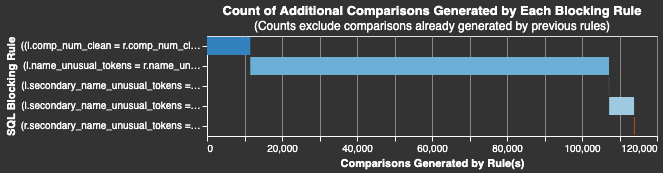

In [70]:
linker.cumulative_num_comparisons_from_blocking_rules_chart(
    list(blocking_rules.values())
)